In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from ast import literal_eval
from sklearn.cluster import (KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering,
                             Birch, MeanShift, AffinityPropagation, OPTICS, HDBSCAN)
from sklearn.mixture import GaussianMixture
import umap.umap_ as umap

import warnings
warnings.filterwarnings("ignore")

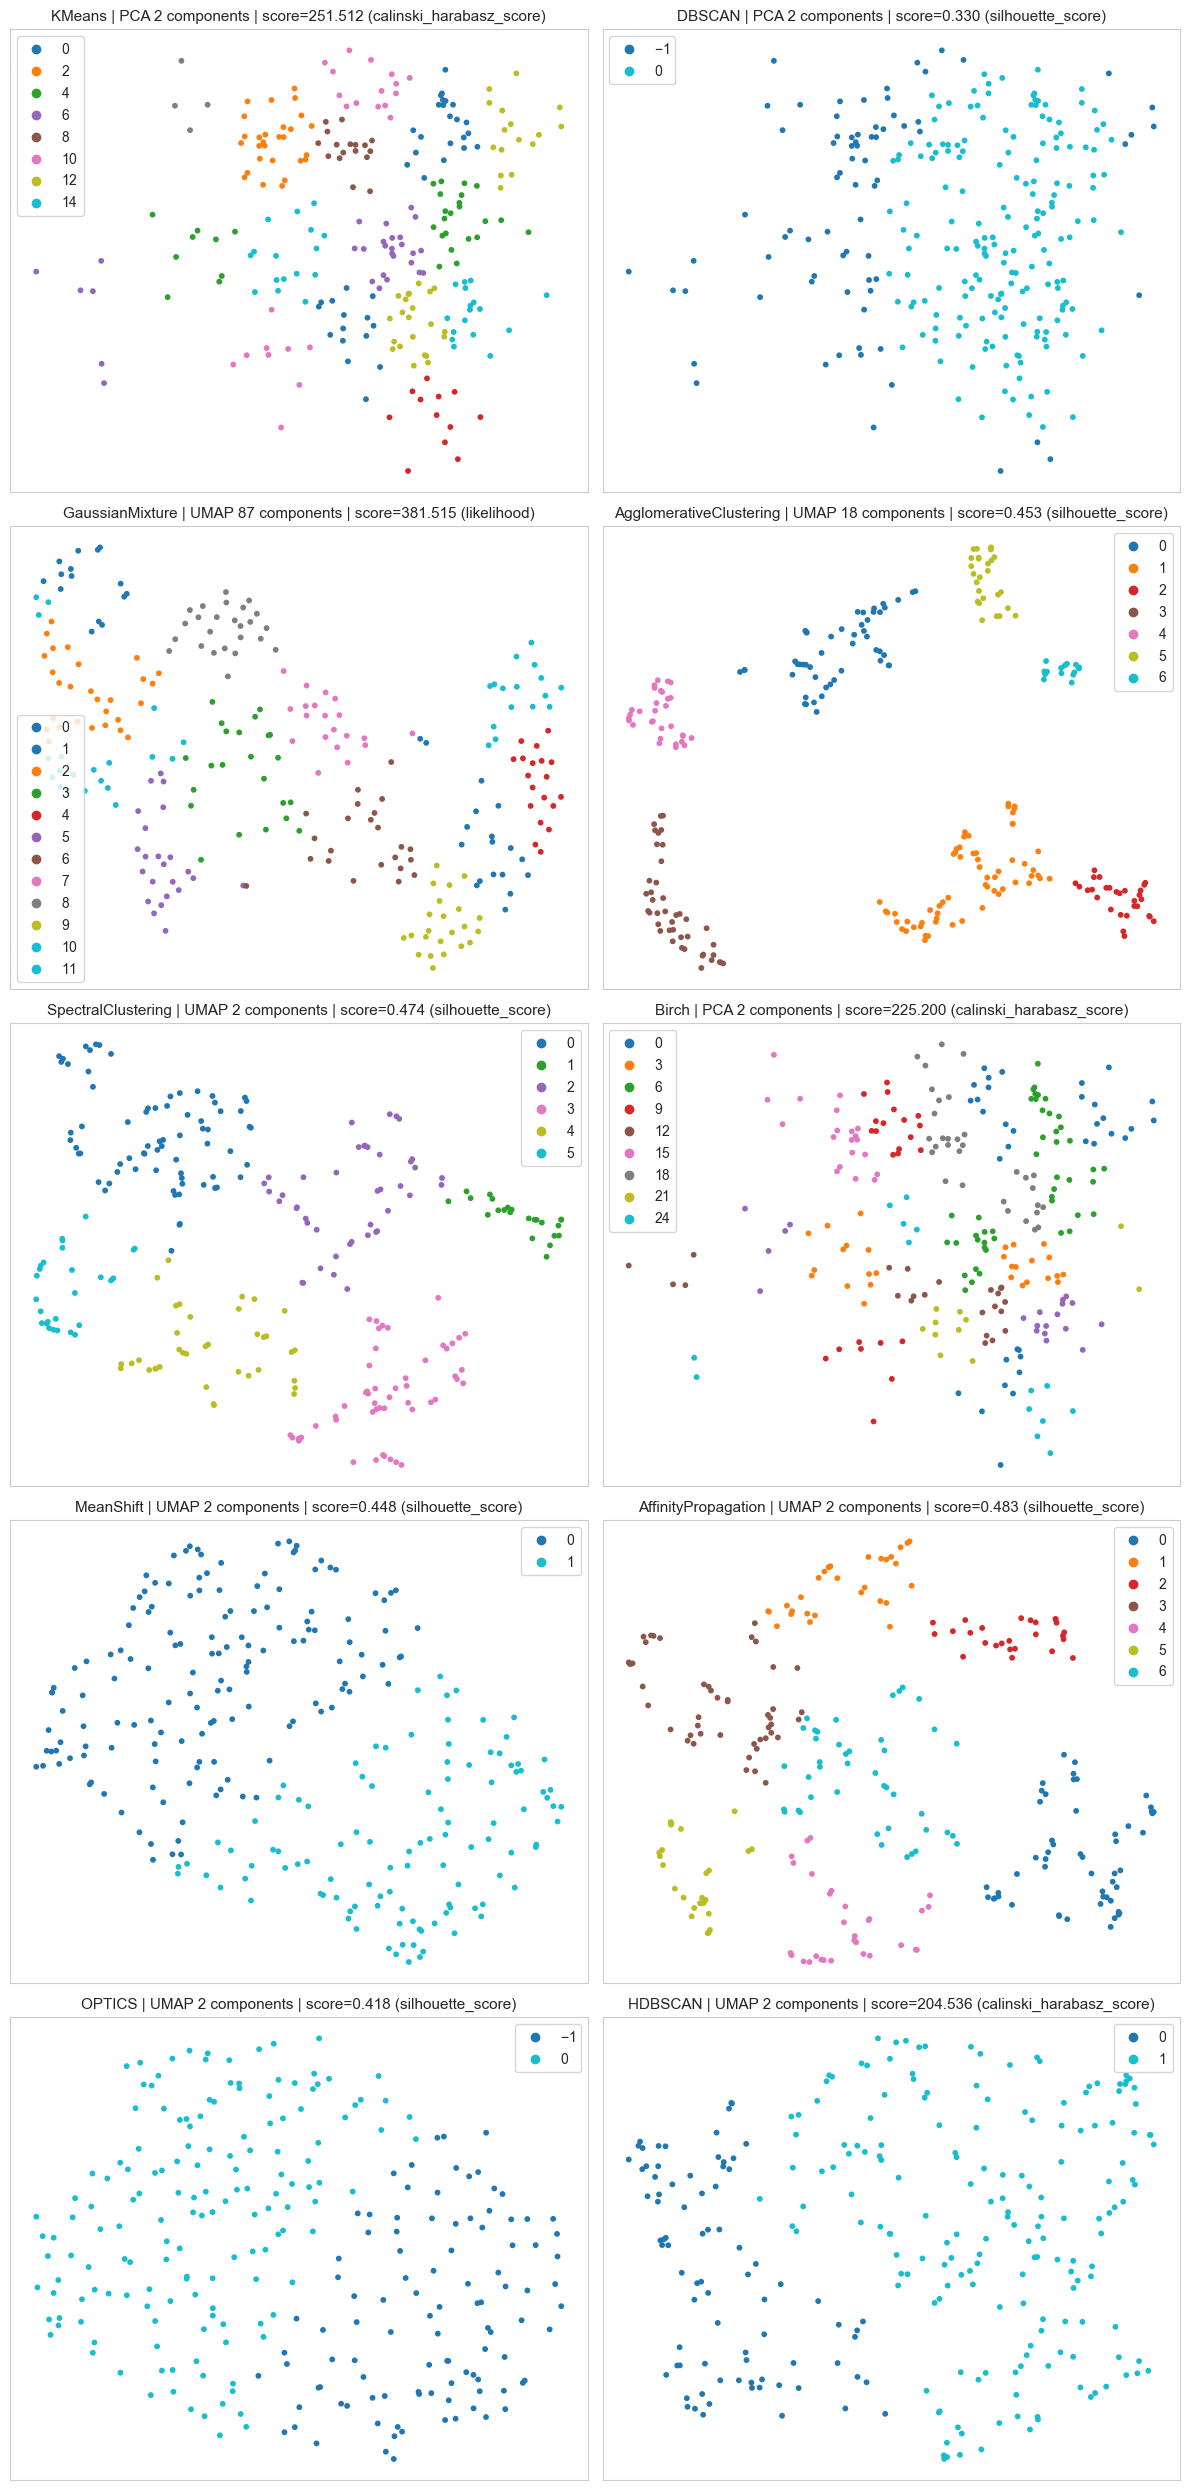

In [21]:
results = pd.read_csv('clustering_results.csv')
df = pd.read_csv('preprocessed/prepared_data.csv')
X_original = df.drop(columns=['КОД3 основной']).values

methods_map = {
    'KMeans': KMeans,
    'DBSCAN': DBSCAN,
    'AgglomerativeClustering': AgglomerativeClustering,
    'SpectralClustering': SpectralClustering,
    'Birch': Birch,
    'MeanShift': MeanShift,
    'AffinityPropagation': AffinityPropagation,
    'GaussianMixture': GaussianMixture,
    'OPTICS': OPTICS,
    'HDBSCAN': HDBSCAN,
}

n = len(results)
fig, axes = plt.subplots(nrows=(n + 1) // 2, ncols=2, figsize=(12, n * 2.5))
axes = axes.flatten()

for i, row in results.iterrows():
    method = row['method']
    params = literal_eval(row['params'])
    score = row['score']
    scoring_metric = row['metric']

    reduction_method = params.pop('dimensionality_reduction', None)
    n_components = None
    
    if reduction_method == 'PCA':
        n_components = params.pop('pca_n_components')
        reducer = PCA(n_components=n_components, random_state=42)
        X = reducer.fit_transform(X_original)
    elif reduction_method == 'UMAP':
        n_components = params.pop('umap_n_components')
        n_neighbors = params.pop('umap_n_neighbors')
        min_dist = params.pop('umap_min_dist')
        reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors,
                            min_dist=min_dist, random_state=42)
        X = reducer.fit_transform(X_original)
    else:
        X = X_original

    model_cls = methods_map[method]
    if method == 'GaussianMixture':
        model = model_cls(**params, random_state=42)
        labels = model.fit(X).predict(X)
    else:
        model = model_cls(**params)
        labels = model.fit_predict(X)

    if X.shape[1] > 2:
        tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
        X_2d = tsne.fit_transform(X)
    else:
        X_2d = X

    ax = axes[i]
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=10)
    ax.legend(*scatter.legend_elements(), loc='best', fontsize=10)

    ax.set_title(f'{method} | {reduction_method} {n_components if n_components else ""} components | score={score:.3f} ({scoring_metric})', fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('cluster_visualizations.png', dpi=300)
plt.show()